In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import csv
import glob
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import solve_ivp


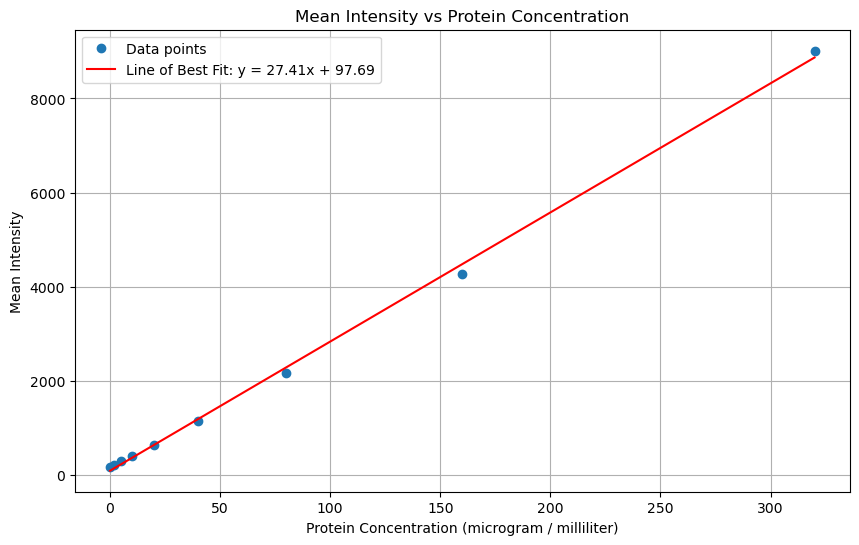

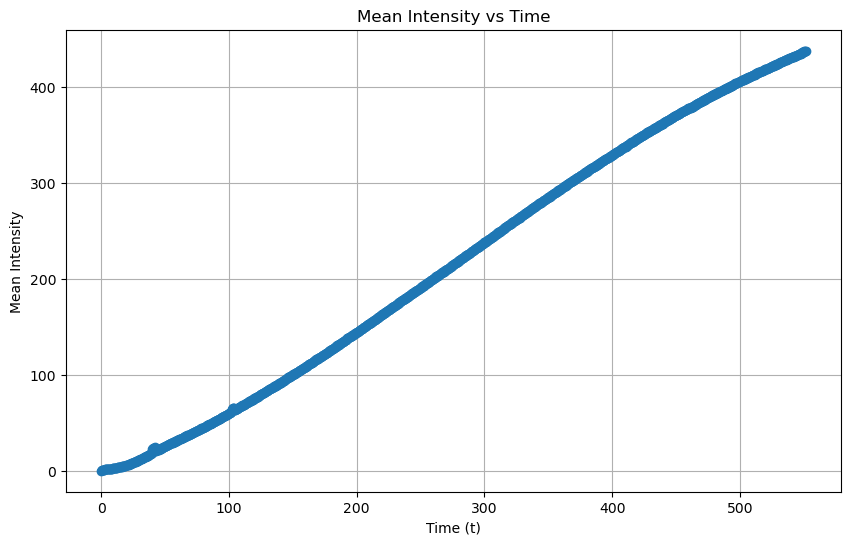

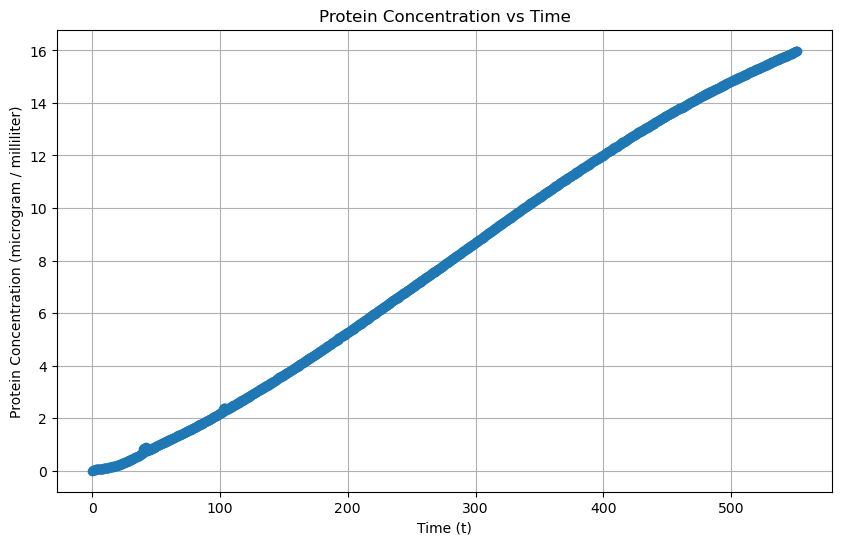

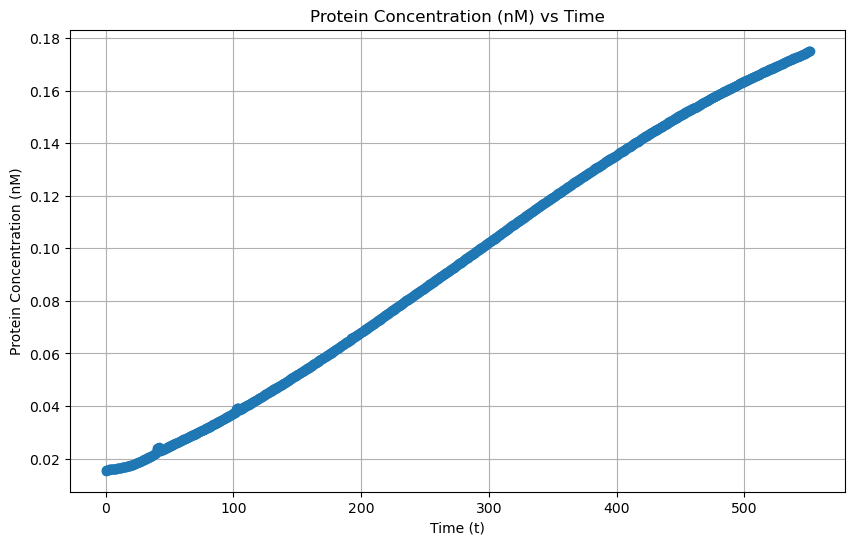

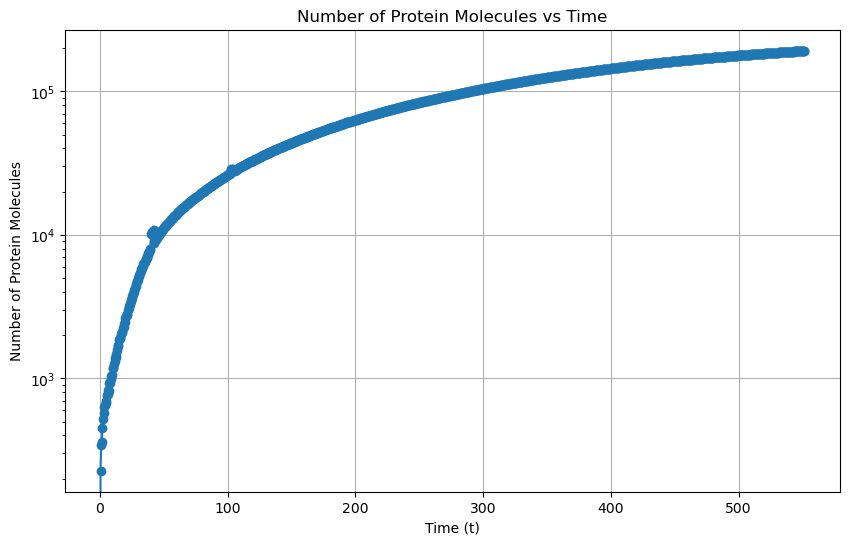

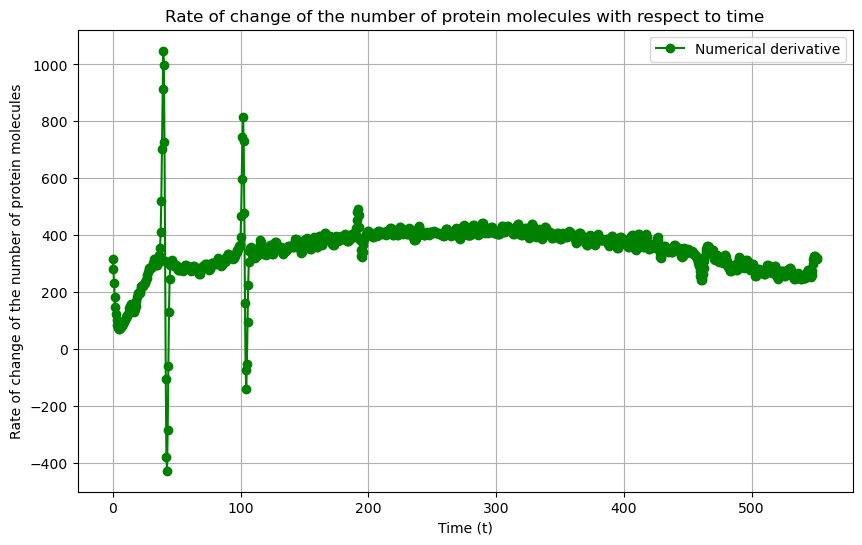

In [10]:

timeValues_List = list()
meanIntensity_List = list()
meanIntensity_CalibrationCurve_List = list()
proteinConcentration_List = list()
proteinConcentration_nM_List = list()
numberOfProteinMolecules_List = list()
rateOfChangeProteinMolecules_List = list()

# This function utilizes the images taken for the experiment of the K401 motor protein
def calculateMeanIntensity(paths):
    for i in range(0, len(paths)): 
        # Load the image as a matrix
        image_path = paths[i]
        image_matrix = io.imread(image_path)
        meanIntensity = image_matrix.mean()
        meanIntensity_List.append(meanIntensity)

# This function utilizes 9 sample images to analyze the relationship between "Mean Intensity" and "Protein Concentration"
def getConcentration(calibrationCurvePaths, mw_kda): # This function takes a list of image paths and molecular weight in kDa as arguments
    for i in range(0, len(calibrationCurvePaths)):
        # Load the image as a matrix
        image_path = calibrationCurvePaths[i]
        image_matrix = io.imread(image_path)
        meanIntensity = image_matrix.mean()
        meanIntensity_CalibrationCurve_List.append(meanIntensity) 

    df = pd.DataFrame(meanIntensity_CalibrationCurve_List).reset_index() # Create a data frame 
    df = df.rename(columns={"index":"Protein Concentration (microgram / milliliter)", 0:"Mean Intensity"})
    sampleConcentration_Values = [0, 2, 5, 10, 20, 40, 80, 160, 320]
    df["Protein Concentration (microgram / milliliter)"] = sampleConcentration_Values

    # Get the equation (linear) of best fit for the Protein Concentration
    x = df["Protein Concentration (microgram / milliliter)"]
    y = df["Mean Intensity"]

    slope, intercept = np.polyfit(x, y, 1) # Multiple return values is allowed in Python
    
    line_of_best_fit = slope * x + intercept
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df["Protein Concentration (microgram / milliliter)"], df["Mean Intensity"], marker='o', linestyle='none', label='Data points')
    plt.plot(x, line_of_best_fit, label=f'Line of Best Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
    plt.title('Mean Intensity vs Protein Concentration')
    plt.xlabel('Protein Concentration (microgram / milliliter)')
    plt.ylabel('Mean Intensity')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Transform the dependent variables
    for i in range(0, len(meanIntensity_List)):
        proteinConcentration = (meanIntensity_List[i] - intercept) / slope
        proteinConcentration_List.append(proteinConcentration)
        proteinConcentration_nM = (proteinConcentration * 1e-6) / (mw_kda * 1e3) * 1e9 # Convert to nM
        proteinConcentration_nM_List.append(proteinConcentration_nM)

def constructDataFrames(timeInterval):
    global meanIntensity_List
    global proteinConcentration_List
    global proteinConcentration_nM_List

    minimumIntensityValue = min(meanIntensity_List)
    adjustedMeanIntensity_List = [x - minimumIntensityValue for x in meanIntensity_List] # Subtract the minimum mean intensity value from ALL values
    meanIntensity_List = adjustedMeanIntensity_List

    minimumProteinConcentration = min(proteinConcentration_List)
    adjustedProteinConcentration_List = [x - minimumProteinConcentration for x in proteinConcentration_List]
    proteinConcentration_List = adjustedProteinConcentration_List

    df = pd.DataFrame(meanIntensity_List).reset_index() # Create a data frame 
    df = df.rename(columns={"index":"Time (min)", 0:"Mean Intensity"})
    df["Time (min)"] = df["Time (min)"] * timeInterval # Manipulate the "time" values

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time (min)'], df['Mean Intensity'], marker='o')
    plt.title('Mean Intensity vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Mean Intensity')
    plt.grid(True)
    plt.show()

    df2 = pd.DataFrame(proteinConcentration_List).reset_index()
    df2 = df2.rename(columns={"index":"Time (min)", 0:"Protein Concentration (nanogram / microliter)"})
    df2["Time (min)"] = df2["Time (min)"] * timeInterval # Manipulate the "time" values
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df2['Time (min)'], df2['Protein Concentration (nanogram / microliter)'], marker='o')
    plt.title('Protein Concentration vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Protein Concentration (microgram / milliliter)')
    plt.grid(True)
    plt.show()

    df3 = pd.DataFrame(proteinConcentration_nM_List).reset_index()
    df3 = df3.rename(columns={"index":"Time (min)", 0:"Protein Concentration (nM)"})
    df3["Time (min)"] = df3["Time (min)"] * timeInterval # Manipulate the "time" values

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df3['Time (min)'], df3['Protein Concentration (nM)'], marker='o')
    plt.title('Protein Concentration (nM) vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Protein Concentration (nM)')
    plt.grid(True)
    plt.show()

def getNumberOfProteinMolecules(dropletVolume, timeInterval):
    global numberOfProteinMolecules_List
    proteinMass_List = [i * dropletVolume for i in proteinConcentration_List] # List comprehension technique
    numberOfProteinMolecules_List = [j * 6000000000 for j in proteinMass_List] # This expression was derived from several intermediate calculations

    df = pd.DataFrame(numberOfProteinMolecules_List).reset_index() # Create a data frame 
    df = df.rename(columns={"index":"Time (min)", 0:"Number of Protein Molecules"})
    df["Time (min)"] = df["Time (min)"] * timeInterval # Manipulate the "time" values

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time (min)'], df['Number of Protein Molecules'], marker='o')
    plt.title('Number of Protein Molecules vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Number of Protein Molecules')
    # y axis log scale
    plt.yscale('log')
    plt.grid(True)
    plt.show()

def getRateOfChangeProteinMolecules(timeInterval):
    global timeValues_List
    global rateOfChangeProteinMolecules_List
    
    p_vals = np.array(numberOfProteinMolecules_List) # Converts a Python list to a numpy array
    length = len(numberOfProteinMolecules_List)
    maxTimeValue = (length - 1) * timeInterval 
    t_vals = np.linspace(0, maxTimeValue, length) # Creates a numpy array
    timeValues_List = t_vals.tolist()

    # Estimate the numerical derivative of the number of protein molecules with respect to time
    dp_dt = np.gradient(p_vals, t_vals)
    rateOfChangeProteinMolecules_List = dp_dt.tolist()

    # apply gaussian filter with sigma 2
    dp_dt = gaussian_filter1d(dp_dt, sigma=2)
    
    # Plot the estimated derivative
    plt.figure(figsize=(10, 6))
    plt.plot(t_vals, dp_dt, label='Numerical derivative', marker='o', color="green")
    plt.xlabel('Time (t)')
    plt.ylabel('Rate of change of the number of protein molecules')
    plt.title('Rate of change of the number of protein molecules with respect to time')
    plt.legend()
    plt.grid(True)
    plt.show()

def saveData(fileName): # Saves the data to a CSV file
    # save dataframes to csv files
    dataFile = open(fileName, 'w', newline="")
    writerCSV = csv.writer(dataFile)
    headerRow = list()
    headerRow.append("Time")
    headerRow.append("Mean Intensity")
    headerRow.append("Protein Concentration (ng/µL)")
    headerRow.append("Protein Concentration (nM)")
    headerRow.append("Number of Protein Molecules (PM)")
    headerRow.append("Rate of Change of Number of PM")
    writerCSV.writerow(headerRow)
    for i in range(0, len(meanIntensity_List)):
        dataRow = list()
        dataRow.append(timeValues_List[i])
        dataRow.append(meanIntensity_List[i])
        dataRow.append(proteinConcentration_List[i])
        dataRow.append(proteinConcentration_nM_List[i])
        dataRow.append(numberOfProteinMolecules_List[i])
        dataRow.append(rateOfChangeProteinMolecules_List[i])
        writerCSV.writerow(dataRow)
    dataFile.close()

def runAnalysis(paths, calibrationCurvePaths, timeInterval, dropletVolume, mw_kda, fileName):
    calculateMeanIntensity(paths) # 1st function to be called
    getConcentration(calibrationCurvePaths, mw_kda) # 2nd function to be called
    constructDataFrames(timeInterval) # Time interval is passed in minutes. # 3th function to be called
    getNumberOfProteinMolecules(dropletVolume, timeInterval) # For the experiment of the K401 protein, the droplet had a volume of 2 microliters. 4th function to be called
    getRateOfChangeProteinMolecules(timeInterval) # 5th function to be called
    saveData(fileName) # 6th function to be called


paths = sorted(glob.glob("./data/k401-activedrops/img_*********_gfp-4x_000.tif"))
calibrationCurvePaths = sorted(glob.glob("./data/calibration_curve/***ugml.tif"))

runAnalysis(paths, calibrationCurvePaths, 0.5, 0.000002, 100, "proteinsData.csv")

# Comprehensive Guide to Cell-Free Protein Synthesis Model

## 1. Biological Background

In cell-free protein synthesis systems, we study the processes of transcription and translation outside of living cells. This allows us to examine these processes in a more controlled environment. The key components are:

1. **DNA**: The template for transcription.
2. **RNA Polymerase**: Enzyme that transcribes DNA into mRNA.
3. **mRNA**: The product of transcription and template for translation.
4. **Ribosomes**: Molecular machines that translate mRNA into proteins.
5. **Amino Acids**: Building blocks of proteins.
6. **Proteases**: Enzymes that degrade proteins.

The process flows as follows: DNA → mRNA → Protein, with protein degradation occurring simultaneously.

## 2. Model Parameters

- $k_{TX}$: Transcription rate [nucleotides/second]
- $k_{TL}$: Translation rate [amino acids/second]
- $N_m$: mRNA length [nucleotides]
- $N_p$: Protein length [amino acids]
- $\tau_m$: mRNA lifetime [seconds]
- $\tau_0$: Transcription delay [seconds]
- $\tau_f$: Protein folding delay [seconds]
- $R_p$: RNA polymerase concentration [nM]
- $R$: Ribosome concentration [nM]
- $K_{TL}$: Michaelis-Menten constant for translation [nM]
- $D$: DNA concentration [nM]
- $k_{deg}$: Protein degradation rate constant [1/second]
- $X_p$: Protease concentration [nM]
- $K_p$: Michaelis-Menten constant for degradation [nM]

## 3. Mathematical Model

### 3.1 mRNA Dynamics

The rate of change of mRNA concentration is given by:

$$\frac{dm}{dt} = k_{TX} \cdot \frac{1}{N_m} \cdot [R_p] \cdot D - \frac{m(t)}{\tau_m}, \quad \forall t > \tau_0$$

#### Dimensional Analysis:

- $\frac{dm}{dt}$: [nM]/[s]
- $k_{TX} \cdot \frac{1}{N_m} \cdot [R_p] \cdot D$: ([nt]/[s]) · (1/[nt]) · [nM] · [nM] = [nM]/[s]
- $\frac{m(t)}{\tau_m}$: [nM]/[s]

#### Solution:

Solving this differential equation, we get:

$$m(t) = m_{ss} \left(1 - e^{-(t - \tau_0)/\tau_m}\right), \quad \forall t > \tau_0$$

Where $m_{ss}$ is the steady-state mRNA concentration:

$$m_{ss} = k_{TX} \cdot \frac{1}{N_m} \cdot [R_p] \cdot D \cdot \tau_m$$

### 3.2 Protein Synthesis

The rate of protein synthesis is:

$$\frac{dp_{syn}}{dt} = \frac{k_{TL} \cdot \frac{1}{N_p}}{1 + \frac{K_{TL}}{R}} \cdot m(t - \tau_f)$$

#### Dimensional Analysis:

- $\frac{dp_{syn}}{dt}$: [nM]/[s]
- $\frac{k_{TL} \cdot \frac{1}{N_p}}{1 + \frac{K_{TL}}{R}} \cdot m(t - \tau_f)$: ([aa]/[s]) · (1/[aa]) · [dimensionless] · [nM] = [nM]/[s]

### 3.3 Protein Degradation

The rate of protein degradation follows Michaelis-Menten kinetics:

$$\frac{dp_{deg}}{dt} = -\frac{k_{deg} \cdot [p] \cdot X_p}{K_p + [p]}$$

#### Dimensional Analysis:

- $\frac{dp_{deg}}{dt}$: [nM]/[s]
- $\frac{k_{deg} \cdot [p] \cdot X_p}{K_p + [p]}$: [1/s] · [nM] · [nM] / [nM] = [nM]/[s]

### 3.4 Overall Protein Dynamics

Combining synthesis and degradation:

$$\frac{dp}{dt} = \frac{k_{TL} \cdot \frac{1}{N_p}}{1 + \frac{K_{TL}}{R}} \cdot m(t - \tau_f) - \frac{k_{deg} \cdot [p] \cdot X_p}{K_p + [p]}$$

## 4. Mathematical Steps

### Solving the mRNA Dynamics Equation

1. Start with:
   $$\frac{dm}{dt} = k_{TX} \cdot \frac{1}{N_m} \cdot [R_p] \cdot D - \frac{m(t)}{\tau_m}$$
   
2. Let $Q = k_{TX} \cdot \frac{1}{N_m} \cdot [R_p] \cdot D$ for simplicity:
   $$\frac{dm}{dt} = Q - \frac{m(t)}{\tau_m}$$
   
3. Rearrange:
   $$\frac{dm}{dt} + \frac{m(t)}{\tau_m} = Q$$
   
4. Multiply by the integrating factor $e^{t/\tau_m}$:
   $$e^{t/\tau_m} \left(\frac{dm}{dt} + \frac{m(t)}{\tau_m}\right) = Q e^{t/\tau_m}$$
   
5. Recognize as derivative:
   $$\frac{d}{dt} \left[m(t) e^{t/\tau_m}\right] = Q e^{t/\tau_m}$$
   
6. Integrate both sides:
   $$\int \frac{d}{dt} \left[m(t) e^{t/\tau_m}\right] dt = \int Q e^{t/\tau_m} dt$$
   
   $$m(t) e^{t/\tau_m} = Q \tau_m e^{t/\tau_m} + C$$
   
7. Solve for $m(t)$:
   $$m(t) = Q \tau_m + C e^{-t/\tau_m}$$
   
8. Apply initial condition $m(\tau_0) = 0$:
   $$0 = Q \tau_m + C e^{-\tau_0/\tau_m}$$
   
   $$C = -Q \tau_m e^{\tau_0/\tau_m}$$
   
9. Final solution:
   $$m(t) = Q \tau_m \left(1 - e^{-(t - \tau_0)/\tau_m}\right)$$
   
10. Substitute back $Q$:
    $$m(t) = k_{TX} \cdot \frac{1}{N_m} \cdot [R_p] \cdot D \cdot \tau_m \left(1 - e^{-(t - \tau_0)/\tau_m}\right)$$

### Deriving $m_{ss}$

Set $\frac{dm}{dt} = 0$ in the original equation:

$$0 = k_{TX} \cdot \frac{1}{N_m} \cdot [R_p] \cdot D - \frac{m_{ss}}{\tau_m}$$

Solve for $m_{ss}$:

$$m_{ss} = k_{TX} \cdot \frac{1}{N_m} \cdot [R_p] \cdot D \cdot \tau_m$$

Finally the complete equation is:
$$m(t) = m_{ss} \left(1 - e^{-(t - \tau_0)/\tau_m}\right)$$


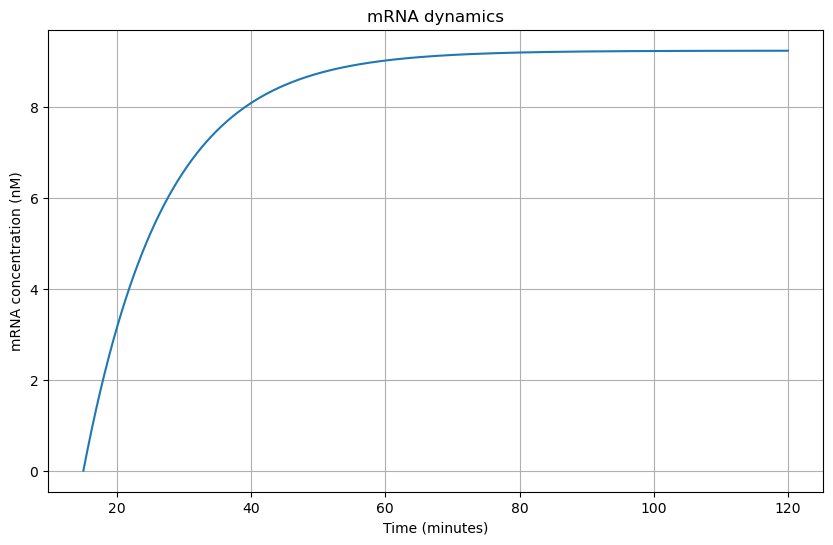

In [11]:
# Parameters
k_TX = 1  # rNTP/s
N_m = 780  # nucleotides
R_p_D = 10  # nM
tau_m = 12 * 60  # 12 minutes in seconds
tau_0 = 15 * 60  # 15 minutes in seconds

# Calculate m_ss
m_ss = tau_m * k_TX / N_m * R_p_D

# Time array
t = np.linspace(tau_0, 3600*2, 1000)  # 1 hour in secondsz

# Calculate m(t)
m = m_ss * (1 - np.exp(-(t - tau_0)/tau_m))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t/60, m)  # Convert time to minutes for plotting
plt.xlabel('Time (minutes)')
plt.ylabel('mRNA concentration (nM)')
plt.title('mRNA dynamics')
plt.grid(True)
plt.show()


### Protein Dynamics

Given:

$$\frac{dp}{dt} = \frac{k_{TL} \cdot \frac{1}{N_p}}{1 + \frac{K_{TL}}{R}} \cdot m(t - \tau_f) - \frac{k_{deg} \cdot p \cdot X_p}{K_p + p}$$

Let $G = \frac{k_{TL} \cdot \frac{1}{N_p}}{1 + \frac{K_{TL}}{R}}$.

Thus, the ODE can be written as:

$$\frac{dp}{dt} = G \cdot m(t - \tau_f) - \frac{k_{deg} \cdot p \cdot X_p}{K_p + p}$$

Previously, we found that $m(t)$ is equal to:

$$m(t) = k_{TX} \cdot \frac{1}{N_m} \cdot [R_p] \cdot D \cdot \tau_m \left(1 - e^{-(t - \tau_0)/\tau_m}\right) \quad \text{for} \quad t \ge \tau_0$$

We can substitute this equation into the ODE; however, we must replace the variable $t$ with $t - \tau_f$:

$$m(t - \tau_f) = k_{TX} \cdot \frac{1}{N_m} \cdot [R_p] \cdot D \cdot \tau_m \left(1 - e^{-(t - \tau_f - \tau_0)/\tau_m}\right)$$

Substituting $m(t - \tau_f)$ into the protein dynamics equation, we get:

$$\frac{dp}{dt} = \frac{k_{TL} \cdot \frac{1}{N_p}}{1 + \frac{K_{TL}}{R}} \cdot k_{TX} \cdot \frac{1}{N_m} \cdot [R_p] \cdot D \cdot \tau_m \left(1 - e^{-(t - \tau_f - \tau_0)/\tau_m}\right) - \frac{k_{deg} \cdot p \cdot X_p}{K_p + p}$$

Simplifying further:

$$\frac{dp}{dt} = \frac{k_{TL} \cdot k_{TX} \cdot [R_p] \cdot D \cdot \tau_m}{N_p \cdot N_m \left(1 + \frac{K_{TL}}{R}\right)} \left(1 - e^{-(t - \tau_f - \tau_0)/\tau_m}\right) - \frac{k_{deg} \cdot p \cdot X_p}{K_p + p} \quad \text{for} \quad t \ge \tau_0 + \tau_f$$

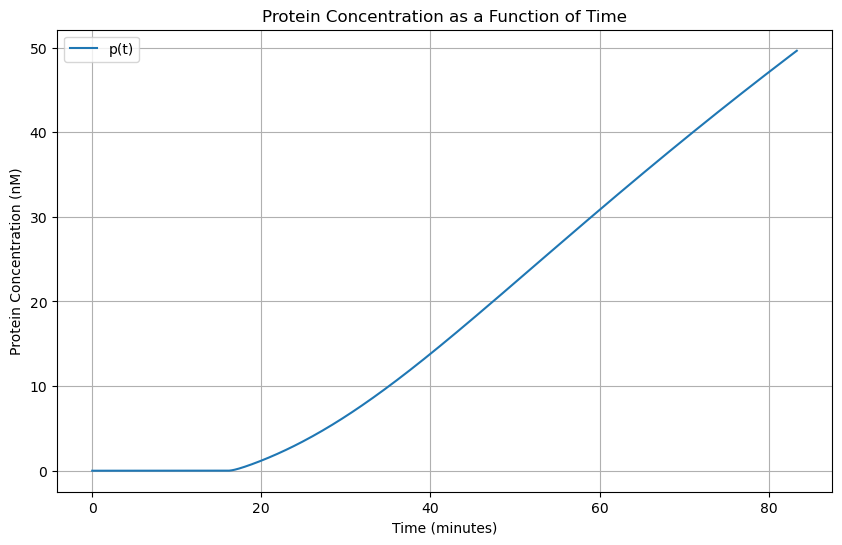

In [13]:
# Calculate dilution factor
txtl_volume = 4e-6  # L (4 µL)
DNA_volume = 1e-6  # L (1 µL)
microtubules_volume = 2e-6  # L (2 µL)
total_volume = txtl_volume + DNA_volume + microtubules_volume  # L (7 µL)
dilution_factor = txtl_volume / total_volume

# Parameters from the documents
k_TX = 1.0  # transcription rate [rNTP/s]
N_m = 3000  # mRNA length [nucleotides]
R_p = 30.0  # RNA polymerase concentration [nM]
D = 30.0  # DNA concentration [nM] %%%% add slider first
tau_m = 720.0  # mRNA lifetime [seconds]
tau_0 = 900.0  # transcription delay [seconds]
K_TX = 1.0  # Michaelis-Menten constant for transcription [nM]
k_TL = 10.0  # translation rate [amino acids/s]
N_p = 592  # protein length [amino acids]
K_TL = 1.0  # Michaelis-Menten constant for translation [nM]
R = 190.0  # ribosome concentration [nM]
tau_f = 60.0  # protein folding delay [seconds]
k_deg = 0.01  # protein degradation rate constant [1/s]
X_p = 9.0  # protease concentration [nM]
K_p = 4.0  # Michaelis-Menten constant for degradation [nM]

# Calculate the [R_p D] complex using the equation in the paper's supplementary information
RpD = 0.5 * (R_p + D + K_TX - np.sqrt((R_p + D + K_TX)**2 - 4 * R_p * D)) # right way to calculate RpD

# Parameters for transcription and translation
Q = (k_TL * k_TX * RpD * tau_m) / (N_p * (1 + k_TL / R) * N_m)  
S = k_deg * X_p
k3 = tau_m
k11 = K_p

# Define the differential equation for protein concentration
def dPdt(T, P):
    if T > tau_0 + tau_f:
        return Q * (1 - np.exp(-(T - tau_0 - tau_f) / k3)) - (S * P) / (k11 + P)
    else:
        return 0

# Initial condition
P_initial = 0  # At t = 0, the protein concentration P(0) = 0

# Time range for the solution
T = np.linspace(0, 5000, 500)  # Time ranges from T = 0 to T = 5000 seconds

# Solve the ODE
solution = solve_ivp(dPdt, [T[0], T[-1]], [P_initial], t_eval=T)

# Plot the solution
plt.figure(figsize=(10, 6))
plt.plot(solution.t / 60, solution.y[0], label='p(t)')  # Convert time to minutes for the plot
plt.xlabel('Time (minutes)')
plt.ylabel('Protein Concentration (nM)')
plt.title('Protein Concentration as a Function of Time')
plt.legend()
plt.grid(True)
plt.show()

## Today:
- plot with sliders (start with just D, then go for the other ones one by one)
- overlap model curve with experiment curve (both nM vs time)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Define the damped harmonic oscillator function
def damped_oscillator(t, A, gamma, omega, phi):
    return A * np.exp(-gamma * t) * np.cos(omega * t + phi)

# Define the simple harmonic oscillator function
def simple_oscillator(t, A_simple, omega_simple, phi_simple):
    return A_simple * np.cos(omega_simple * t + phi_simple)

# Create a function to plot the oscillators with given parameters
def plot_oscillators(A, gamma, omega, phi):
    t = np.linspace(0, 10, 1000)
    x_damped = damped_oscillator(t, A, gamma, omega, phi)
    
    # Static parameters for the simple harmonic oscillator
    A_simple = 1.0
    omega_simple = 1.0
    phi_simple = 0.0
    x_simple = simple_oscillator(t, A_simple, omega_simple, phi_simple)

    plt.figure(figsize=(10, 6))
    plt.plot(t, x_damped, label='Damped Harmonic Oscillator')
    plt.plot(t, x_simple, label='Simple Harmonic Oscillator', linestyle='--', color='orange')
    plt.title('Damped vs Simple Harmonic Oscillator')
    plt.xlabel('Time (t)')
    plt.ylabel('Displacement (x)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive sliders for the damped oscillator parameters
interact(plot_oscillators,
         A=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='Amplitude (A)'),
         gamma=FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='Damping (γ)'),
         omega=FloatSlider(value=1.0, min=0.5, max=5.0, step=0.1, description='Frequency (ω)'),
         phi=FloatSlider(value=0.0, min=0.0, max=2 * np.pi, step=0.1, description='Phase (φ)'))

interactive(children=(FloatSlider(value=1.0, description='Amplitude (A)', max=2.0, min=0.1), FloatSlider(value…

<function __main__.plot_oscillators(A, gamma, omega, phi)>